In [1]:
# Necessary imports
%load_ext autoreload
%autoreload 2

import networkx as nx
import numpy as np
import pandas as pd
import scipy.sparse as sps

from TCGAMultiOmics.multiomics import MultiOmicsData
from moge.visualization.plot_data import matrix_heatmap, plot_coo_matrix

import seaborn
import matplotlib.pyplot as plt
from moge.network.omics_distance import *


# Import the TCGA cancer data

In [7]:
import pickle
with open('moge/data/luad_data_longest.pickle', 'rb') as file:
    luad_data = pickle.load(file)

In [2]:
folder_path = "/data/datasets/Bioinformatics_ExternalData/tcga-assembler/LUAD/"
external_data_path = "/data/datasets/Bioinformatics_ExternalData/"
luad_data = MultiOmicsData(cancer_type="LUAD", tcga_data_path=folder_path, external_data_path=external_data_path,
                           modalities=[\
                                       "GE",
                                       "MIR",
                                       "LNC",
                                       # "CNV",
                                       # "SNP",
#                                        "PRO",
                                       # "DNA"
                                       ])

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


Unmatched lncRNAs 12727
Unmatched lncRNAs after gencode: 1033
Unmatched lncRNAs after lncBase: 812
Unmatched lncRNAs after HGNC: 758
Unmatched lncRNAs after lncipedia: 622
PATIENTS (522, 110)
DRUGS (461, 4)
GE (576, 20157)
MIR (494, 1870)
LNC (546, 12727)
SAMPLES (599, 111)
Processed genes info for  GE
Processed genes info for  MIR
Processed genes info for  LNC


/opt/anaconda3/lib/python3.6/site-packages/TCGAMultiOmics/genomic.py:948: FutureWarning: 'MiRBase ID' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  self.gene_info = self.gene_info.join(self.targetScan_family_df.groupby("MiRBase ID").first(), on="MiRBase ID", how="left")


In [5]:
LNC = luad_data.LNC.get_genes_info()
MIR = luad_data.MIR.get_genes_info()
GE = luad_data.GE.get_genes_info()
print(GE.columns)
print(MIR.columns)
print(LNC.columns)

Index(['Transcript ID', 'Gene ID', 'Gene description', '3P-seq tags',
       'locus_type', 'location', 'gene_family', 'gene_family_id',
       'Transcript sequence', 'GO Terms', 'Disease association', 'Chromosome',
       'Chromosome arm', 'Chromosome region', 'Transcript length'],
      dtype='object')
Index(['miR family', 'Seed+m8', 'Transcript sequence', 'Family Conservation?',
       'MiRBase Accession', 'MiRBase ID', 'location', 'ensembl_gene_id',
       'Disease association', 'locus_type', 'Transcript length', 'GO Terms',
       'Rfams'],
      dtype='object')
Index(['Gene ID', 'Gene Name', 'HGNC Gene Name', 'Transcript id',
       'Transcript name', 'Transcript type', 'tag', 'Chromosome', 'start',
       'end', 'Strand', 'locus_type', 'Transcript sequence',
       'Disease association', 'GO Terms', 'Rfams'],
      dtype='object')


In [21]:
# node_list = GE[GE["gene_family"].notnull()].index[0:1000]
node_list = GE.index
# correlation_dist = compute_expression_correlation_dists(luad_data, modalities=["GE"],
#                                                         node_list=node_list, absolute_corr=True,
#                                                         squareform=False)
affinity = compute_annotation_affinities(GE, node_list=node_list,
                features=["GO Terms", "Disease association"], 
#                features=["Family", "tag", "Strand", "Chromosome"], 
#                                          correlation_dist=correlation_dist,
                                        nanmean=True, 
#                                          weights=[1, 1, 0.5, 0.5, 5],
                                        )


Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)
/home/jonny/PycharmProjects/MultiOmicsGraphEmbedding/moge/network/omics_distance.py:53: RuntimeWarning: Mean of empty slice
  agg_func = lambda x: np.nanmean(x, axis=0)


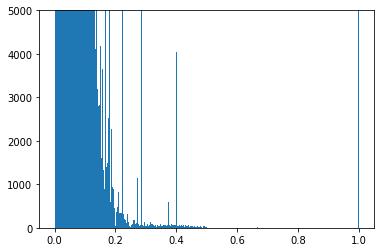

In [22]:
plt.hist(affinity[np.where(~np.isnan(affinity))].reshape((-1)), bins=500)
plt.ylim(top=5000)
plt.show()

In [23]:
threshold=0.6
print("threshold at", threshold,":",(affinity > threshold).sum())
# print("threshold at", threshold,":",(affinity < 0.01).sum())

/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


threshold at 0.6 : 119652


/home/jonny/.conda/envs/jonny_conda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


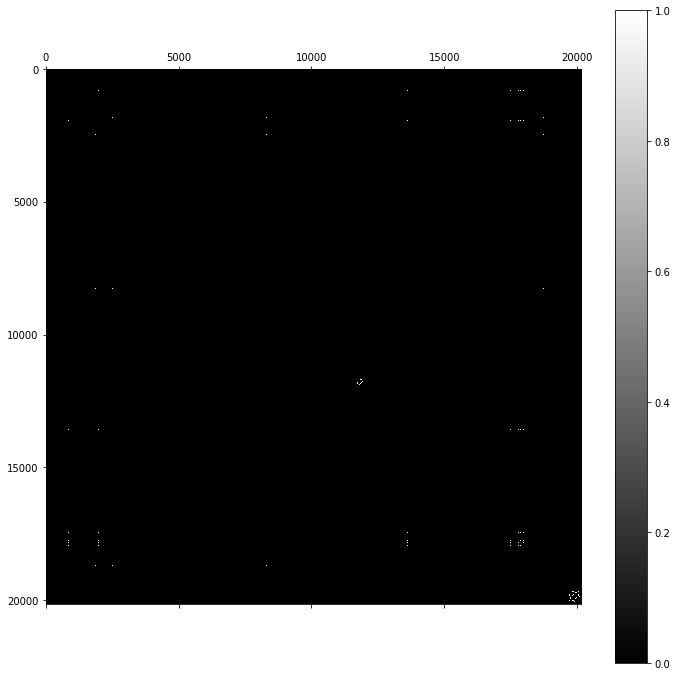

In [24]:
matrix_heatmap(np.array(affinity>threshold, dtype=float))

# Heterogeneous Network

In [3]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=luad_data)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


## Write node labels to file

In [4]:
from moge.network.file_io import write_node_labels_to_file

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_family.tsv", luad_data, 
#                           label_cols=["family"],
#                           modalities=["MIR", "GE", "LNC"], 
#                           get_dummies=False)

# write_node_labels_to_file("moge/data/lncRNA_miRNA_mRNA/lncRNA-miRNA-mRNA_node_labels_disease_dummies.tsv", luad_data, 
#                           label_cols=["Disease association"],
#                           modalities=["MIR", "GE", "LNC"], remove_na=True, sep="\t",
#                           get_dummies=True)

# Add Attribute Affinity Positive Edges

In [5]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

Gower's dissimilarity: Computing GO Terms , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


Gower's dissimilarity: Computing Disease association , dtype: object , shape: (20157,)
Dice distance


/opt/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to bool by check_pairwise_arrays.
  warnings.warn(msg, DataConversionWarning)


KeyboardInterrupt: 

In [ ]:
affinities_GE = network.add_edges_from_nodes_similarity(modality="GE", node_list=network.nodes["GE"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=False,
                                        features=["locus_type", "gene_family_id"], 
                                        compute_correlation=False)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Disease association"], 
                                        compute_correlation=False)

In [ ]:
affinities_MIR = network.add_edges_from_nodes_similarity(modality="MIR", node_list=network.nodes["MIR"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["Family", "Rfams"], 
                                        compute_correlation=False)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.3,
                                        negative_sampling_ratio=5.0, 
                                        nanmean=False,
                                        features=["locus_type", "Transcript type", "tag", "Strand", "Chromosome"],
                                        weights=[1, 1, 1, 0.5, 0.5, 5],
                                        compute_correlation=True)

In [ ]:
affinities_LNC = network.add_edges_from_nodes_similarity(modality="LNC", node_list=network.nodes["LNC"], 
                                        similarity_threshold=0.70, dissimilarity_threshold=0.01,
                                        negative_sampling_ratio=5.0, nanmean=True,
                                        features=["GO Terms", "Family", "Disease association"], 
                                        compute_correlation=False)

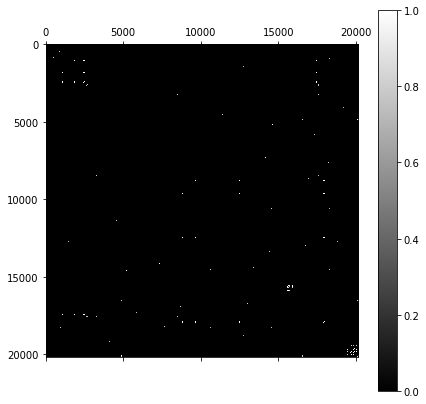

In [7]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["GE"]).todense(),
              figsize=(7,7))

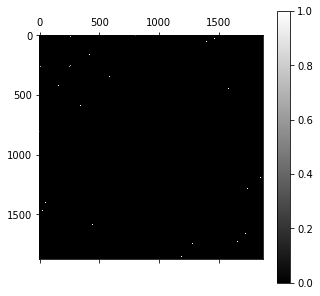

In [8]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["MIR"]).todense(),
              figsize=(5,5))

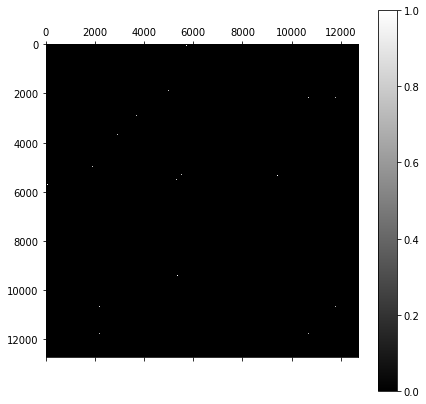

In [9]:
matrix_heatmap(network.get_adjacency_matrix(edge_types=["u"], node_list=network.nodes["LNC"]).todense(),
              figsize=(7,7))

In [4]:
# IMPORT Affinity Edgelist
network.G.import_edgelist_file("moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_NoExpression_affinity.edgelist", 
                               is_directed=False)

In [18]:
# WRITE Affinity Edgelist
# nx.write_edgelist(network.get_subgraph(["MIR", "GE", "LNC"]), 
#                   "moge/data/LMN_only_directed/affinity/lmn_n70_m70_l70-70_GO_Rfams_Disease_Family_GO_affinity.edgelist", 
#                   data=True)

# Add Attribute Affinity NEGATIVE Edges between cross-modals

In [11]:
u_n_size = 10000
network.add_sampled_negative_edges(u_n_size, modalities=["GE", "MIR"])
network.add_sampled_negative_edges(u_n_size*2, modalities=["GE", "LNC"])
network.add_sampled_negative_edges(u_n_size, modalities=["LNC", "MIR"])

Number of negative sampled edges between ['GE', 'MIR'] added: 10000
Number of negative sampled edges between ['GE', 'LNC'] added: 20000
Number of negative sampled edges between ['LNC', 'MIR'] added: 10000


# Add Regulatory Interaction edges

In [10]:
mirtarbase_new = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=True, data=False)
mirtarbase_old = luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False, data=False)
mirtarbase_diff = list(set(mirtarbase_new) - set(mirtarbase_old))
len(mirtarbase_diff)

64749

In [12]:
# Adds miRNA-target interaction network
network.add_directed_edges_from_edgelist(edgelist=mirtarbase_diff, # luad_data.MIR.get_miRTarBase_miRNA_target_interaction(use_latest=False), 
                                        modalities=["MIR", "GE"], correlation_weights=False, threshold=0.20,
                                        database="miRTarBase")

Adding edgelist with 1746 total unique MIR genes (source), but only matching 1615 nodes
Adding edgelist with 4740 total unique GE genes (target), but only matching 4616 nodes
64749 edges added.


In [13]:
starbase_new = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=1, data=False)
starbase_old = luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2, data=False)
starbase_diff = list(set(starbase_new) - set(starbase_old))
len(starbase_diff)

1516287

In [14]:
# Adds Gene Regulatory Network edges
network.add_directed_edges_from_edgelist(edgelist=starbase_diff, #luad_data.GE.get_starBase_RNA_RNA_interactions(min_expNum=2), # unweighted edges
                                        modalities=["GE", "GE"], correlation_weights=False, threshold=0.2,
                                        database="starBase")

Adding edgelist with 16044 total unique GE genes (source), but only matching 15866 nodes
Adding edgelist with 30955 total unique GE genes (target), but only matching 15484 nodes
1516287 edges added.


In [15]:
npinter_new = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=True, data=False)
npinter_old = luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False, data=False)
npinter_diff = list(set(npinter_new) - set(npinter_old))
len(npinter_diff)

123486

In [16]:
# Adds miRNA-lncRNA interaction network
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_starBase_lncRNA_miRNA_interactions_edgelist(),
#                                         )
# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRNome_miRNA_binding_sites_edgelist(),
#                                          modalities=["LNC", "MIR"], correlation_weights=False, threshold=0.20,
#                                         database="lncRNome")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncBase_miRNA_lncRNA_interactions_edgelist(),
#                                          modalities=["MIR", "LNC"], correlation_weights=False, threshold=0.20,
#                                         database="lncBase")

network.add_directed_edges_from_edgelist(edgelist=npinter_diff, #luad_data.LNC.get_NPInter_ncRNA_RNA_regulatory_interaction_edgelist(use_latest=False),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="NPInter")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_LncReg_lncRNA_RNA_regulatory_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="LncReg")

Adding edgelist with 9381 total unique LNC genes (source), but only matching 508 nodes
Adding edgelist with 2903 total unique GE genes (target), but only matching 1607 nodes
123486 edges added.


In [20]:
lnc2tar_low = luad_data.LNC.get_lncrna2target_low_throughput_interactions(data=False)
lnc2tar_high = luad_data.LNC.get_lncrna2target_high_throughput_interactions(data=False)
lnc2tar_diff = list(set(lnc2tar_low) - set(lnc2tar_high))
len(lnc2tar_diff)

/opt/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


1277

In [27]:
network.add_directed_edges_from_edgelist(edgelist=lnc2tar_diff, #luad_data.LNC.get_lncrna2target_high_throughput_interactions(),
                                         modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
                                        database="lncrna2target_high")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncrna2target_low_throughput_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncrna2target_low")

# network.add_directed_edges_from_edgelist(edgelist=luad_data.LNC.get_lncRInter_interactions(),
#                                          modalities=["LNC", "GE"], correlation_weights=False, threshold=0.20,
#                                         database="lncRInter")

Adding edgelist with 243 total unique LNC genes (source), but only matching 79 nodes
Adding edgelist with 677 total unique GE genes (target), but only matching 454 nodes
1277 edges added.


# Filter the node_list

In [28]:
isolates = list(nx.isolates(network.G))

In [29]:
network.nodes["GE"] = [node for node in network.nodes["GE"] if node not in isolates]
network.nodes["LNC"] = [node for node in network.nodes["LNC"] if node not in isolates]
network.nodes["MIR"] = [node for node in network.nodes["MIR"] if node not in isolates]
network.node_list = [node for node in network.node_list if node not in isolates]

In [30]:
# network.remove_extra_nodes() # Also makes network unmutable

In [31]:
network.G.number_of_nodes()

38517

In [32]:
len(network.node_list)

32580

In [33]:
# WRITE FULL network
import pickle
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'wb') as file:
    pickle.dump(network, file)

# Split train-test by edges

In [45]:
import pickle
# WRITE READ network
with open('moge/data/LMN_future_recall/Predict/Interactions_Affinity/LMN_mirtarbase_starbase_lncbase_npinter_lncrna2target.test.pickle', 'rb') as file:
    network = pickle.load(file)

In [27]:
from moge.evaluation.utils import split_train_test_edges

network_train, test_edges, val_edges = split_train_test_edges(network, network.node_list, 
#                                                                            databases=,
                                                          test_frac=.00, val_frac=.20, edge_types=["d"], 
                                                          seed=0, verbose=True)

preprocessing...
edges_to_remove 345875
edges_to_remove (after MST) 345875
test_edges_size 0
val_edges_size 69175
Removed 0 test, and 69175 val, type ['d'] edges


In [28]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)

MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581
MIR  nodes: 1870
GE  nodes: 20157
LNC  nodes: 12706
Total nodes: 34733
Genes info columns: ['Transcript sequence', 'Disease association', 'locus_type', 'GO Terms', 'Family']
Number of nodes without seq removed: 2153
Total nodes (filtered): 32581


# Split train-test by nodes

In [ ]:
from moge.evaluation.utils import split_train_test_nodes

network_train, test_edges, val_edges, test_nodes, val_nodes = split_train_test_nodes(network, network.nodes["LNC"],
                                                          test_frac=.00, val_frac=.10, edge_types=["d"], 
                                                          seed=0, verbose=True)

In [ ]:
from moge.network.heterogeneous_network import HeterogeneousNetwork

network_test = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_val = HeterogeneousNetwork(modalities=["MIR", "GE", "LNC"], multi_omics_data=network.multi_omics_data)
network_test.val_node_list = test_nodes
network_val.val_node_list = val_nodes
network_test.G.add_edges_from(test_edges)
network_val.G.add_edges_from(val_edges)
len(network_test.node_list), len(network_val.node_list)

In [ ]:
network_train.G.number_of_edges()

# Write train-test-val split as separate networks

In [29]:
# WRITE
import pickle
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.pickle', 'wb') as file:
    pickle.dump(network_train, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_test.pickle', 'wb') as file:
    pickle.dump(network_test, file)
    
with open('moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_val.pickle', 'wb') as file:
    pickle.dump(network_val, file)

In [30]:
# WRITE Edgelist
nx.write_edgelist(network_train.get_subgraph(["MIR", "GE", "LNC"]), 
                  "moge/data/LMN_only_directed/lmn_edges20/lmn_edges20_train.full.edgelist", 
                  data=False)

In [34]:
# Write edgelist interactions only
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], node_list=network.node_list)),
                  "moge/data/LMN_future_recall/Predict/Interactions_Only/lmn_train.interactions.edgelist",
                  data=False)

In [39]:
# Write edgelist interactions only, database specific
nx.write_edgelist(nx.Graph(incoming_graph_data=network.get_edgelist(edge_types=["d"], databases=["starBase"], node_list=network.node_list)),
                  "moge/data/LMN_future_recall/Predict/Interactions_Only/GE/lmn_train.starBase.interactions.edgelist",
                  data=False)

## Network Info & Visualizations

In [ ]:
print(len(network.G.nodes()))
print(len(network.G.edges()))

In [ ]:
csr_un = network.get_adjacency_matrix(edge_types=["u_n"], node_list=network.node_list)
csr_u = network.get_adjacency_matrix(edge_types=["u"], node_list=network.node_list)
csr_d = network.get_adjacency_matrix(edge_types=["d"], node_list=network.node_list)

In [ ]:
matrix_heatmap(csr_un.toarray())

In [ ]:
matrix_heatmap(csr_u.toarray())

In [ ]:
matrix_heatmap(csr_d.toarray())